# Model Improvement - Part 2

## Introduction
In this section, we will improve the baseline model developed in Part 1. We'll analyze the model's errors, implement various improvements, and compare the performance of the improved model to the baseline model.


## Error Analysis and Conclusions

Based on the error analysis conducted in Part 1, we had the following conclusion:

- **Overestimation and Underestimation**: The model tends to overestimate more

- **Feature Importance**: Features like `Monthly.Premium.Auto` and `Location.Code` are significant contributors to predictions and also to the samples with prediction errors.

- **Outliers**: Many errors occur in cases of outliers values of the target feature - the `Total.Claim.Amount`.

### Work Plan:
1. Feature engineering:

   -  Implement feature transformations when necessary
   -  Apply standard scaling to ensure consistent scale among features
2. Remove or handle outliers in data.
3. Perform hyperparameter tuning to optimize the model.
4. Compare imporved model to the baseline model
5. Use feature importance methods to find important features driving model predictions.
6. Generate insights from the data

Note, we do not need to handle missing values as the XGboost model is designed to deal with Nans


# Data Loading and Preprocessing



#### Load Dataset

In [1]:
# Data Loading and Preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("data/car_insurance.csv")


#### Drop irrelevant columns

We drop features that are irrevelevant to prediction of total claim value, like geographic coordinates and Customer ID.

In [2]:
# Drop or encode 'Location.Geo' if it's irrelevant or highly variable
# Here, assuming it's dropped because it's a geographic coordinate and less relevant
data = data.drop(columns=['Location.Geo'])

# we will also drop columns which are not important
data = data.drop(columns=['CustomerID'], axis=1)

data['Income'] = pd.to_numeric(data['Income'], errors='coerce')

#### One-hot encode categorical features

We one-hot encode all categorical featues for XGBoost model

In [3]:
# Encode binary categorical features using LabelEncoder
binary_cols = ['Gender']
le = LabelEncoder()
for col in binary_cols:
    data[col] = le.fit_transform(data[col])

# One-hot encode multi-category features
categorical_cols = ['Coverage', 'Education', 'EmploymentStatus', 'Policy.Type','Marital.Status',    
                    'Policy', 'Renew.Offer.Type', 'Sales.Channel', 'Vehicle.Class','Location.Code','Vehicle.Size']

data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

#### Split data into 80% train and 20% test sets.

In [4]:
random_state = 21
# Split data into features (X) and target (y)
X = data.drop(columns=['Total.Claim.Amount'])
y = data['Total.Claim.Amount']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


 ### Baseline Model for Comparison

 We examine the performance metrics of our baseline Xgboost model from part 1



In [5]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
# Baseline Model: XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=random_state, n_estimators=100, max_depth=3)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_baseline = xgb_model.predict(X_test)

# Evaluate performance
r2_baseline = r2_score(y_test, y_pred_baseline)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)  # MSE ללא הפרמטר squared
rmse_baseline = np.sqrt(mse_baseline)  
mae_baseline = mean_absolute_error(y_true=y_test, y_pred=y_pred_baseline)
pearson_baseline = pearsonr(y_test,y_pred_baseline)[0]


print(f"Baseline Model Performance:\nR²: {r2_baseline:.3f}\nPearson correlation: {pearson_baseline}\nRMSE: {rmse_baseline:.3f}\nMAE: {mae_baseline:.3f}" )


Baseline Model Performance:
R²: 0.808
Pearson correlation: 0.8988761130209766
RMSE: 129.199
MAE: 85.222


### Examine outliers in the data

- These boxplots visualizes the distributions of all numerical features in the dataset. 

- This visualization will help us to identify features with significant number of outliers.

- Handling these outliers can help improve the performance of our machine-learning model


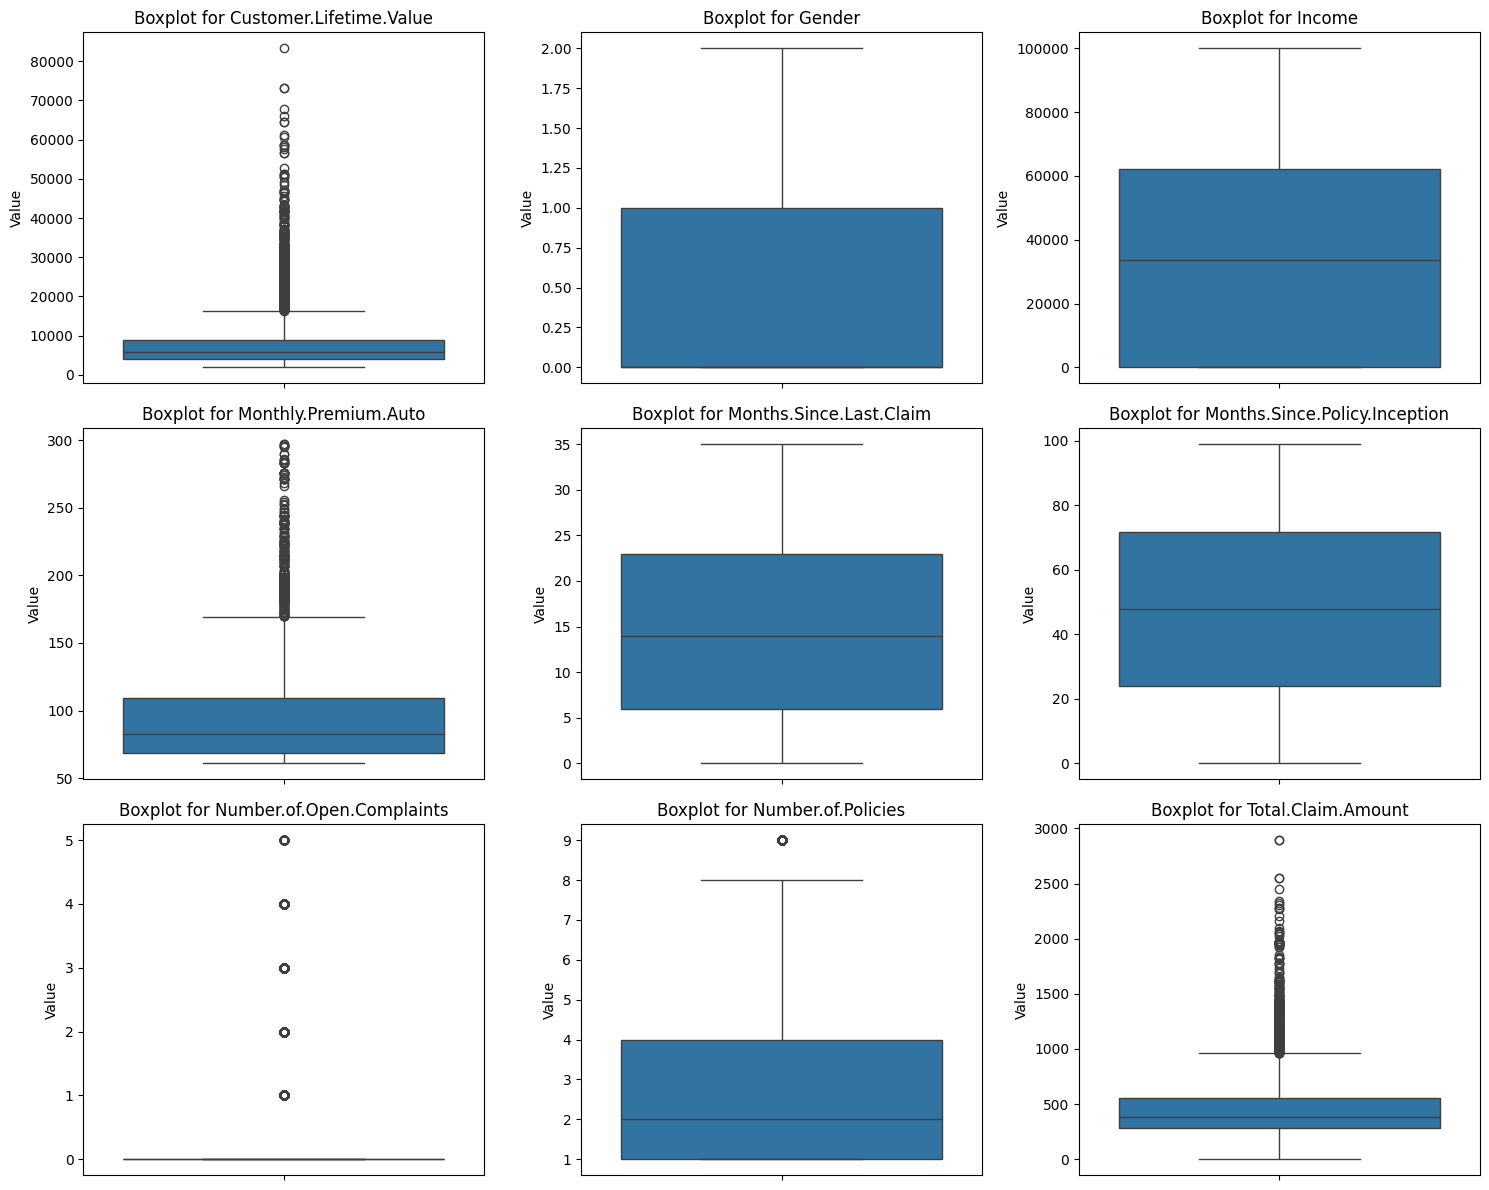

In [6]:
def visualize_outliers(data):
    # Select only numerical features
    numerical_features = data.select_dtypes(include=['number'])

    # Create subplots for each feature
    num_features = numerical_features.columns
    n_features = len(num_features)
    n_cols = 3  # Number of columns in the subplot grid
    n_rows = (n_features + n_cols - 1) // n_cols  # Calculate rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), sharey=False)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.boxplot(data=numerical_features[feature], ax=axes[i])
        axes[i].set_title(f"Boxplot for {feature}")
        axes[i].set_ylabel("Value")
        axes[i].set_xlabel("")

    # Turn off any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()
    
visualize_outliers(data)


- From the plots, we observe that feature we such as `Customer.Lifetime.Value` and `Monthly.Premium.Auto`, exhibit a high number of outliers compared to other features.

- Also the target feature - `Total.Claim.Amount` - has a significant amount of outliers. 


### Clip outlier values based on quantiles

- We handle  outliers using the Interquartile Range (IQR) method. 

- For each feature, values outside 1.5 times the IQR below the first quartile or above the third quartile are clipped to the nearest bound.

- Ths limits extreme values without removing data points.

In [7]:
import numpy as np

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Function to clip outliers
def clip_outliers(dataset, reference_dataset):


    dataset = dataset.copy()  # Ensure the dataset is not modified in-place
    numerical_features = dataset.select_dtypes(include=['number'])
    for feature in numerical_features:
        if feature in reference_dataset.columns:
            Q1 = reference_dataset[feature].quantile(0.25)  # 25th percentile
            Q3 = reference_dataset[feature].quantile(0.75)  # 75th percentile
            IQR = Q3 - Q1  # Interquartile range
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Clip the outliers in the dataset
            dataset[feature] = np.clip(dataset[feature], lower_bound, upper_bound)
        else:
            print(f"Warning: Feature '{feature}' not found in reference dataset.")
            
    return dataset


# Apply clipping to train and test datasets
train_data = clip_outliers(train_data, train_data)
test_data = clip_outliers(test_data, train_data)  # Use train_data as reference for testing



## Feature engireering

### Examine skewerness of numerical features

- We calculate the skew of the distributions of the numerical features in the data. 

- This allows us to identify features where the data is heavily skewed, either to the left (negative skew) or to the right (positive skew)

Skewness of features:
 Number.of.Policies               1.206256
Monthly.Premium.Auto             1.134997
Customer.Lifetime.Value          0.969654
Total.Claim.Amount               0.506639
Income                           0.282134
Months.Since.Last.Claim          0.281124
Gender                           0.253375
Months.Since.Policy.Inception    0.034173
Number.of.Open.Complaints        0.000000
dtype: float64


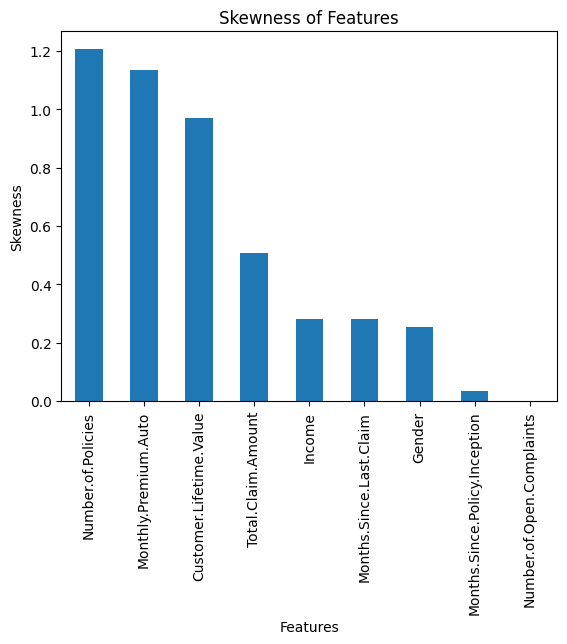

In [8]:

numerical_features = train_data.select_dtypes(include=['number'])
feature_skewness = numerical_features.skew()
feature_skewness=feature_skewness.sort_values(ascending=False)
print("Skewness of features:\n", feature_skewness)

feature_skewness.plot(kind='bar')
plt.title('Skewness of Features')
plt.ylabel('Skewness')
plt.xlabel('Features')
plt.show()


- Based on the skewerness plot, features like `Customer.Lifetime.Value`, `Number.of.Open.Complaints`, and `Monthly.Premium.Auto` are highly right-skewed, indicating the presence of extreme values (outliers). 

- We will handle these skewed fetures using feature a log transformation

### Handling skewerness with log transformation

- This code applies the log transformation to highly skewed numerical features ( we defined as features with absolute skewness > 0.8). 

- The log transformation is used to stabilize the variance of the skewed disributions and make it closer to the normal distribution

In [9]:
import numpy as np

high_skew_features = feature_skewness[feature_skewness > 0.8].index

def apply_log_transform(dataset, high_skew_features):
    """
    Apply log transformation to specified features in the dataset.
    Handles NaN values by applying the transformation only to non-NaN values.
    """
    # Apply log transformation to non-NaN values
    for feature in high_skew_features:
        non_nan_mask = dataset[feature].notna()  # Mask for non-NaN values
        dataset.loc[non_nan_mask, feature] = np.log1p(dataset.loc[non_nan_mask, feature])

    return dataset

# Apply log transformation to train and test datasets
train_data = apply_log_transform(train_data, high_skew_features)
test_data = apply_log_transform(test_data, high_skew_features)



### Apply standard scaling

- We standardize the numerical features in the dataset to have consistent scales. 
- Standardization scales the features to have a mean of 0 and a standard deviation of 1
- This standardization makes the features more suitable for many machine learning models that are sensitive to feature scales

In [ ]:
from sklearn.preprocessing import StandardScaler

# Function for standard scaling
def standard_scaling(train_data, test_data):
    """
    Scales numerical features using StandardScaler. Fits on train_data
    and applies the same scaler to test_data to avoid data leakage.
    """
    # Select numerical features
    numerical_features = train_data.select_dtypes(include=['number']).columns

    # Initialize the scaler
    scaler = StandardScaler()

    scaler.fit(train_data[numerical_features])
    
    # Fit the scaler on training data and transform both train and test
    train_scaled = scaler.transform(train_data[numerical_features])
    test_scaled = scaler.transform(test_data[numerical_features])

    # Convert scaled data back to DataFrame
    train_scaled = pd.DataFrame(train_scaled, columns=numerical_features, index=train_data.index)
    test_scaled = pd.DataFrame(test_scaled, columns=numerical_features, index=test_data.index)

    # Update the original datasets with scaled numerical features
    train_data.update(train_scaled)
    test_data.update(test_scaled)

    return train_data, test_data

# Apply scaling
train_data, test_data = standard_scaling(train_data, test_data)


### Prepare train & test data

We drop the target columns from the train and test data

In [11]:
X_train = train_data.drop(columns=['Total.Claim.Amount'])
y_train = train_data['Total.Claim.Amount']

X_test = test_data.drop(columns=['Total.Claim.Amount'])
y_test = test_data['Total.Claim.Amount']


## Grid Search to optimize model parameters

- This code performs hyperparameter tuning for an XGBoost regression model.

- It evaluates multiple combinations of hyperparmeters to minimize the mean absolute error (MAE).

- It performs cross-validation to evaluate combinations of model parameters from a parameter grid, selecting the best combination with the lowest cross-validation MAE.

In [ ]:
from xgboost import XGBRegressor, cv, DMatrix
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define parameter grid including L2 regularization (reg_lambda)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01,0.1, 0.2]
}

# Prepare data in DMatrix format for XGBoost
dtrain = DMatrix(X_train, label=y_train) 
dtest = DMatrix(X_test, label=y_test) 

# Custom hyperparameter tuning
best_params = None
best_score = float("inf")

for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for learning_rate in param_grid['learning_rate']:
            params = {
                'objective': 'reg:squarederror',
                'random_state': random_state,
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'learning_rate': learning_rate,
            }
            # Perform cross-validation
            cv_results = xgb.cv(
                params=params,
                dtrain=dtrain,
                num_boost_round=n_estimators,
                nfold=5,
                metrics="mae",
                early_stopping_rounds=10,
                seed=42
            )
            
            mean_mae = cv_results['test-mae-mean'].min()

            if mean_mae < best_score:
                best_score = mean_mae
                best_params = params

print("Best Parameters:", best_params)
print("Best CV MAE:", best_score)

# Train final model with best parameters
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)  

# Evaluate on test set
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test Set MAE: {mae:.3f}")


## Analyzing the Improved Model

### Comparing imporved model against baseline

We will compare the baseline model's performance to the tuned model's performance. The metrics we use are:
1. Pearson Correlation
2. R² 

- We deceided to use these metrics as they are both insensitive to the scale of data, which changed with our feature transformations and standard scaling .

- The goal is to assess whether our pipeline and hyperparameter tuning has significantly improved the model.


In [13]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Tuned model performance
r2_tuned = r2_score(y_test, y_pred)
pearson_tuned = pearsonr(y_test,y_pred)[0]

# Print comparison
print("Baseline Model Performance:")
print(f"R²: {r2_baseline:.3f}, Pearson correlation: {pearson_baseline:.3f}")

print("\nTuned Model Performance:")
print(f"R²: {r2_tuned:.3f},Pearson correlation {pearson_tuned}")


Baseline Model Performance:
R²: 0.808, Pearson correlation: 0.899

Tuned Model Performance:
R²: 0.838,Pearson correlation 0.9154546223404052


### Model Performance Metrics:
| Metric              | Baseline Model | Tuned Model |
|---------------------|----------------|-------------|
| R²                  | 0.808          | 0.838       |
| Pearson correlation | 0.899          | 0.915       |

### Conclusions:
1. The tuned model demonstrates measurable improvement in both R² and Pearson correlation metrics.

2. The increase in R² demontrates that the improved model explains more of the variance in the data.

3. The increase in Pearson correlation demonstrates stronger agreement between predicted and actual values


## Error Analysis

To better understand the model's weaknesses, we analyze:
1. Graph of predictions vs. True Values
2. Residuals (difference between actual and predicted values)
3. Distribution of residuals


### Predictions Vs True Values
We examine the scatter plot of improved model predictions on the test verses the true values which allows us to visually examine the models errors

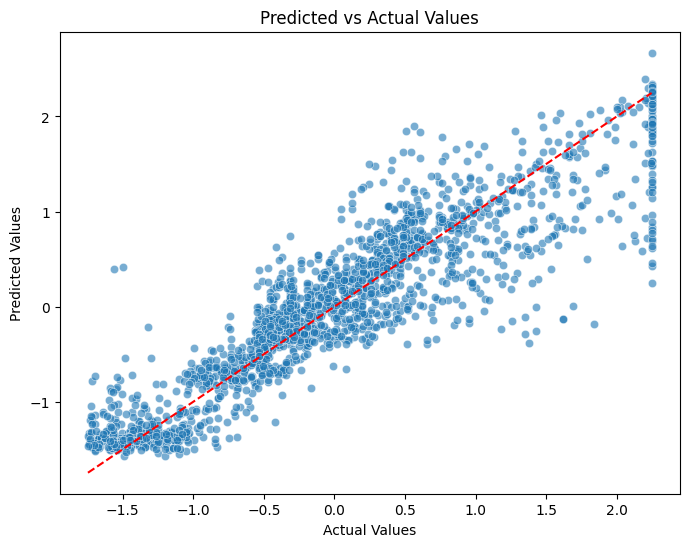

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals
residuals = y_test - y_pred

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()



- The scatter plot shows a generally strong correlation and most predictions are centred around the regression line.

-  However, some predictions still deviate significantly even after model improvement, which may indicate there are still potential outliers or noise in the data

- The plot shows that the errors show a wider spread as the true values are higher, which indicates that the model has more difficulty with prediction in higher insurance claim values

### Residuals Scatter Plot

We created a residuals scatter plot which shows the spread of residuals aound the zero line

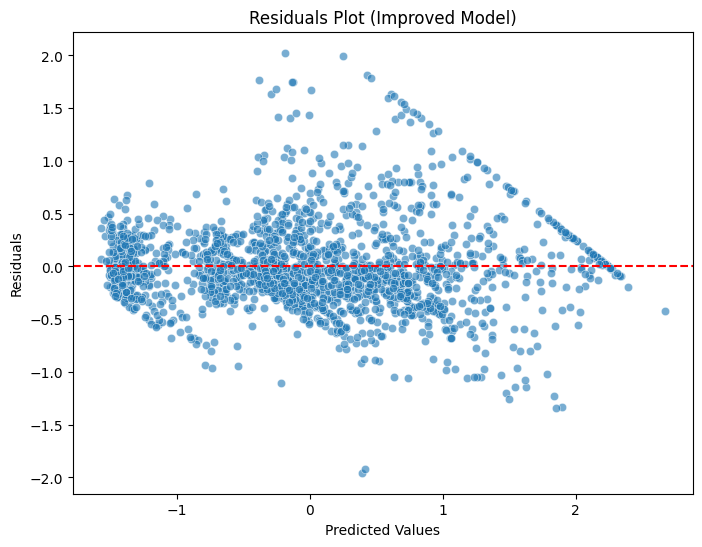

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Plot (Improved Model)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()



The residuals show a wider spread for larger predicted values (toward the right) and a tighter spread for smaller predicted values (toward the left).
This indicates that the model might perform better for smaller predicted values and worse for larger ones

### Distribution of the residuals

- This histograms shows that distibution of residual values. 
- From the disribution we can identify trends of the model to overestimate or underestimate in prediction

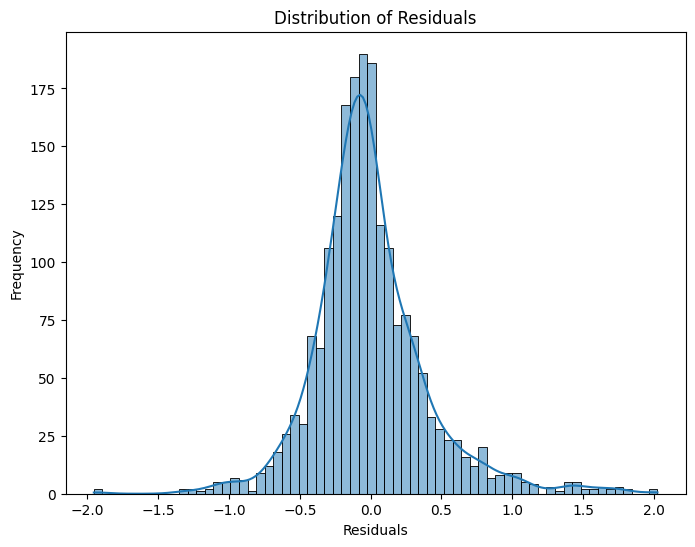

In [16]:
# Residuals distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

- The residual histogram is very close to a normal distribution, but it is slightly right skewed which indicates the model tends to overestimate more.

- Most of the residuals are centered around zero but there are still siginifcant deviations in predictions for some examples. 

- Note that the scale different than the original scale because of the standardization process


## Feature Importance Analysis

We used common feature attribution methods to identify key features that influence model predictions.

### Model-specific attribution method

- We first analyze featue importance using an Xgboost-specific feature attribution method.

- This feature importance plot highlights the most influential features in predicting the target variable (`Total.Claim.Amount`).


<Figure size 1000x800 with 0 Axes>

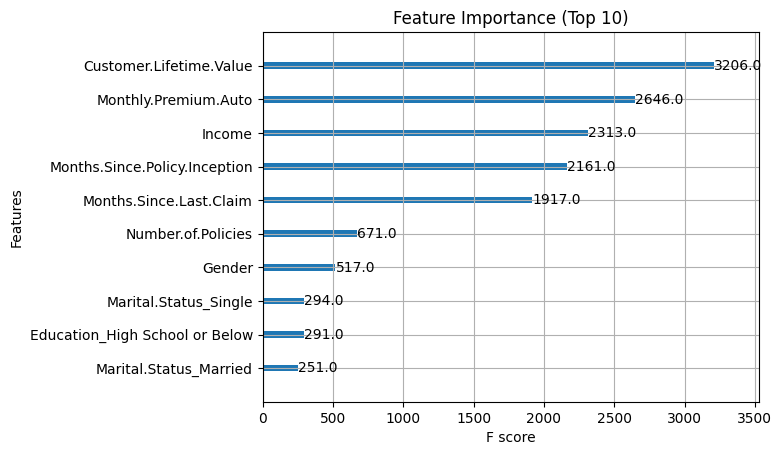

In [17]:
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(best_model, importance_type="weight", max_num_features=10)
plt.title("Feature Importance (Top 10)")
plt.show()



- `Customer.Lifetime.Value` is the most important feature, suggesting customers with higher lifetime values tend to have higher claim amounts.

- `Monthly.Premium.Auto` is the another significant feature, indicating that a customerthat pay more tend to file higher total claims.

- `Income` of customers is also highly predictive of their insurance claim amounts.

- The least important features for model predictions are `Married Status` and `Education Level`.


## SHAP

- We use SHAP (SHapley Additive exPlanations) to compute feature importance. 
- SHAP is an interpretability method based on SHapley values from game theory and is commonly used to explain individual predictions of a machine-learning model

We create a SHAP values visualization of the most importance features driving model preditions on the test set.

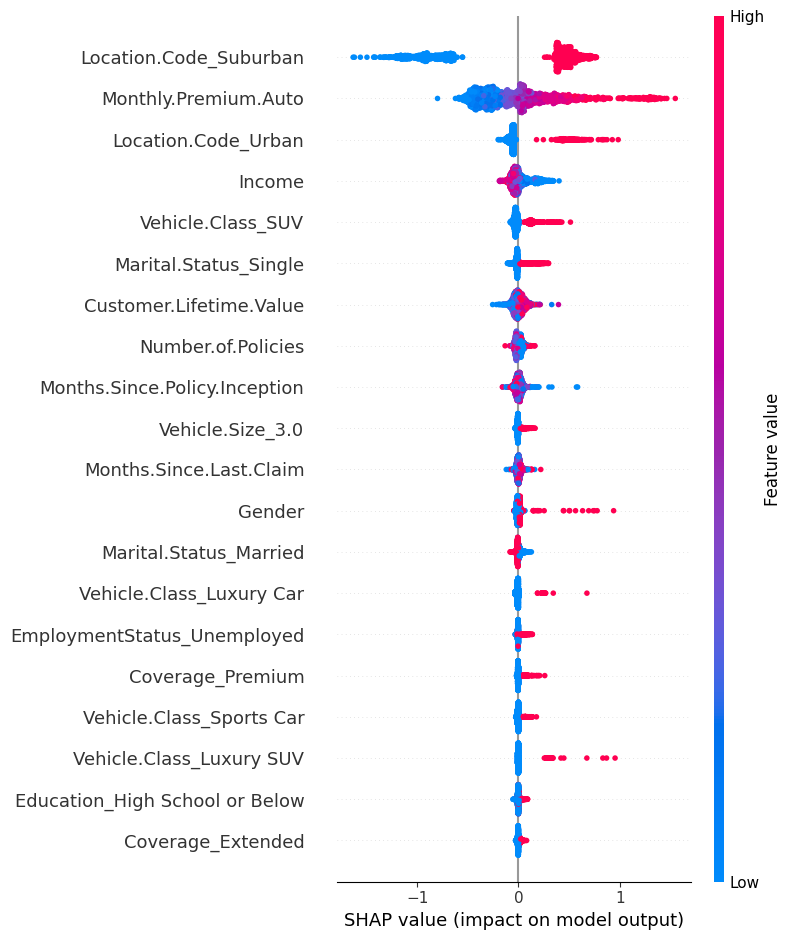

In [18]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

# Step 1: Ensure all columns are numeric
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Step 2: Handle missing values
X_test = X_test.fillna(X_test.median())

# Step 3: Convert boolean columns to integers
bool_columns = X_test.select_dtypes('bool').columns
X_test[bool_columns] = X_test[bool_columns].astype('int')


# Step 5: SHAP Explanation
# Initialize SHAP explainer
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)




- `Location Code` is the most significant feature, indicating that a customer's location is highly predictive of their total insurance claims. Customers in Suburban areas tend to file higher claims.

- `Monthly.Premium.Auto` is another critical factor, suggesting customers who pay more money to the insurance company tend to file higher claim amounts.

- `Income` is another predictive of insurance claim amounts

- The least important features for model predictions are `Education` and `Coverage Extended`.

Surprisingly, the SHAP visualization shows a different ranking of feature importance than the model specific method. In the model specific method, location code was not among the most important featurs and in SHAP it appears as the most important feature.

## Biases or trends

We check for feature correlations of all the numerical featurs in the data against the target feature.

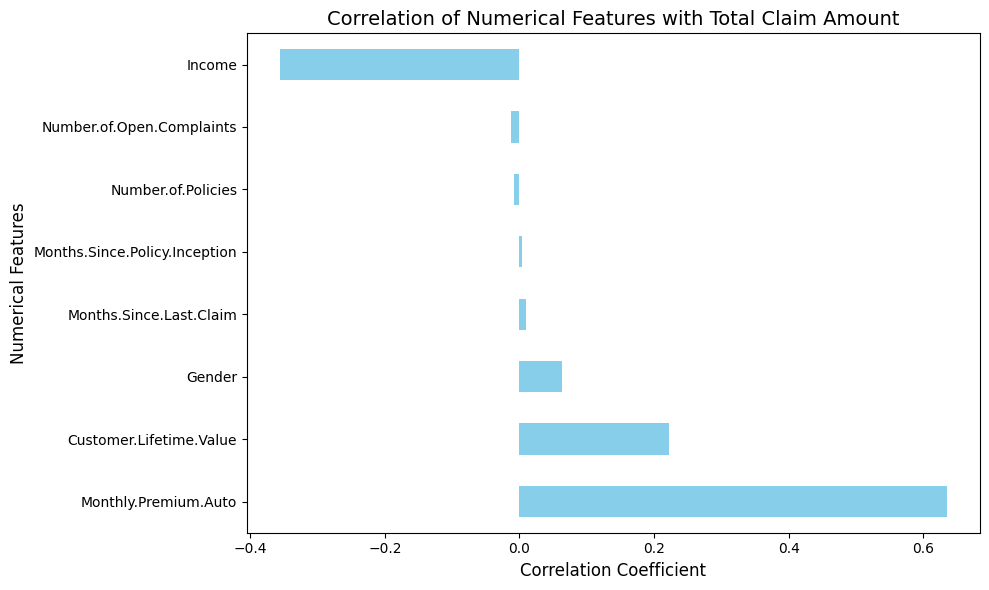

In [19]:
# Filter numerical features
numerical_features = data.select_dtypes(include=['float64', 'int64'])

# Calculate correlations with the target
correlations = numerical_features.corr()['Total.Claim.Amount'].sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(10, 6))
correlations.drop('Total.Claim.Amount').plot(kind='barh', color='skyblue')  # Exclude the target itself
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Numerical Features', fontsize=12)
plt.title('Correlation of Numerical Features with Total Claim Amount', fontsize=14)
plt.tight_layout()
plt.show()

- We observe that `Monthly.Premium.Auto` has high correlation withour target variable, in aggreement with the feature importance analysis. 

- Also the `Customer.Lifetime.Value` has a moderate correlation with the target variable, in agreement with the intepretability methods.

- `Income` has a negative correlation with the target variable, which agrees with the SHAP analysis that reveald that lower income values contribute to increasing predictions.

## Data Insights

- Monthly premium amount are positively associated with claim amounts and also positevly associated with model predictions, which makes sense because customers that pay more for car insurance are generally identified as having a higher risk for car accidents.

- Lower income customers are predicted by the model to file more claims than higher income customers.

- Some surprising findings include the high influence of location code - specifically Suburban areas-  on the the prediction of customer claim amounts. 

- It is also surprising that the customer's lifetime value has a positve influence on model predictions, as customers with higher lifetime values are generally those that pay more to the insurance company and file less claims.


## Potential Applications

- The insights identified by the data analysis pipeline and the model's feature importance could be used to guide the company in determining the premiums for customers

- For instance, the model feature importance revealed that customers from specific location code are predicted to file higher insurance claim. The insurance company can use this insight when determining premium amount for customers from these areas.

- In our data analysis we also found a negative correlation between income and insurance claims. This insight can guide the insurance company when determining premium price for customers with a certain incomes.

